## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


sns.set(style="whitegrid")


## 2. Load Dataset

In [3]:
df = pd.read_csv('../data/raw/togo-dapaong_qc.csv', parse_dates=['Timestamp'])  
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN


## 3. Summary Statistics & Missing Values

In [5]:
print("Summary statistics:\n", df.describe())
print("\nMissing values:\n", df.isna().sum())
print("\nColumns with >5% missing values:\n", (df.isna().mean() > 0.05))


Summary statistics:
                            Timestamp            GHI            DNI  \
count                         525600  525600.000000  525600.000000   
mean   2022-04-25 12:00:30.000000768     230.555040     151.258469   
min              2021-10-25 00:01:00     -12.700000       0.000000   
25%              2022-01-24 06:00:45      -2.200000       0.000000   
50%              2022-04-25 12:00:30       2.100000       0.000000   
75%              2022-07-25 18:00:15     442.400000     246.400000   
max              2022-10-25 00:00:00    1424.000000    1004.500000   
std                              NaN     322.532347     250.956962   

                 DHI           ModA           ModB           Tamb  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      116.444352     226.144375     219.568588      27.751788   
min         0.000000       0.000000       0.000000      14.900000   
25%         0.000000       0.000000       0.000000      24.200000   
50%

## 4. Outlier Detection with Z-score

Number of outliers per column:
 GHI        305
DNI       1062
DHI       3415
ModA       137
ModB       206
WS        3510
WSgust    3915
dtype: int64


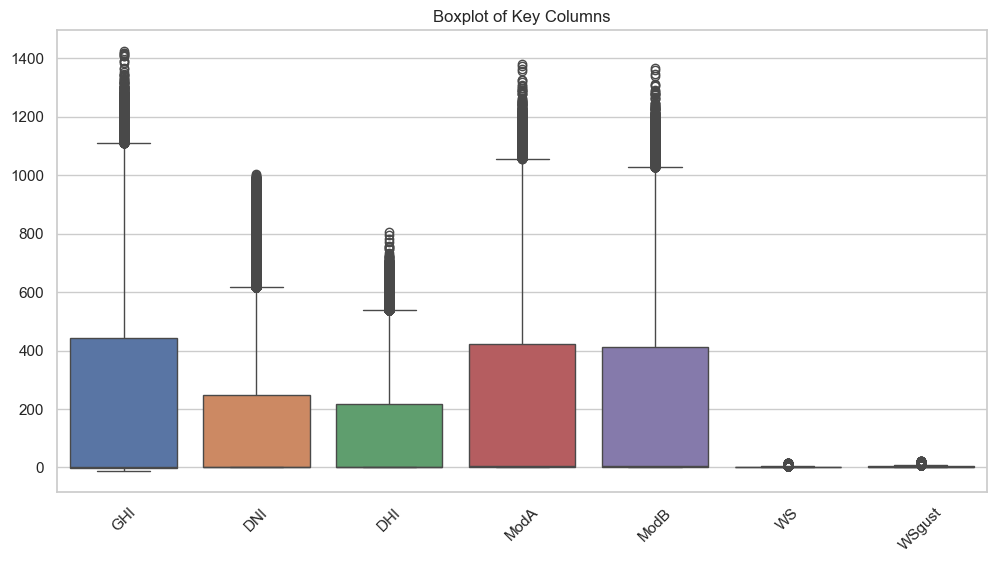

In [6]:

from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[columns].apply(zscore)

outliers = (z_scores.abs() > 3).sum()
print("Number of outliers per column:\n", outliers)


plt.figure(figsize=(12,6))
sns.boxplot(data=df[columns])
plt.xticks(rotation=45)
plt.title("Boxplot of Key Columns")
plt.show()

## 5. Handling Missing Values & Outliers

In [8]:
df[columns] = df[columns].fillna(df[columns].median())

df_clean = df[(z_scores.abs() <= 3).all(axis=1)]
print(f"Rows before cleaning: {len(df)}, after cleaning: {len(df_clean)}")

Rows before cleaning: 525600, after cleaning: 516349


## 6. Time Series Analysis

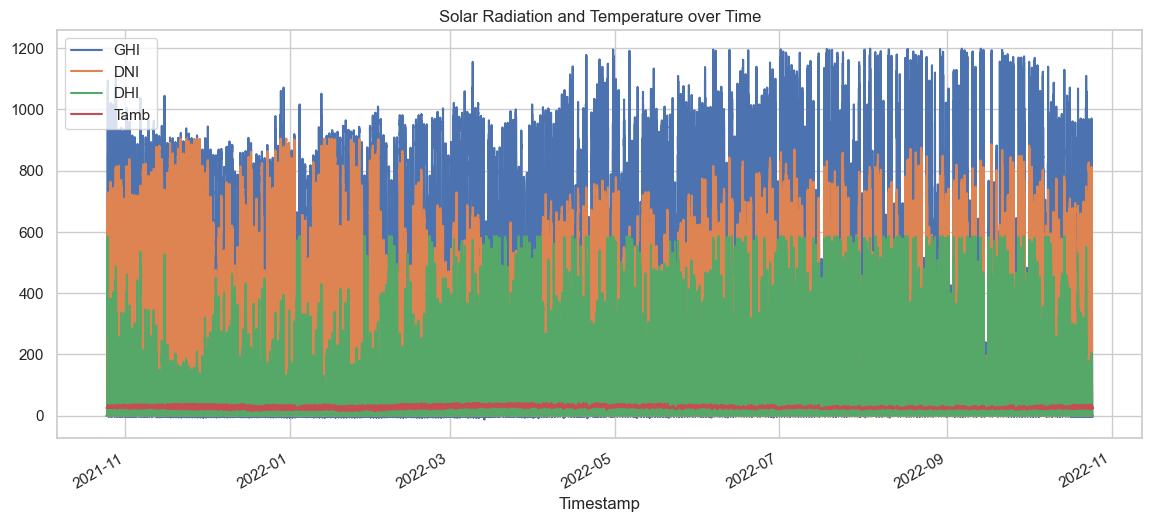

In [18]:
df_clean.set_index('Timestamp', inplace=True)
df_clean[['GHI', 'DNI', 'DHI', 'Tamb']].plot(figsize=(14,6))
plt.title("Solar Radiation and Temperature over Time")
plt.show()

## 7. Cleaning Impact on Sensor Readings

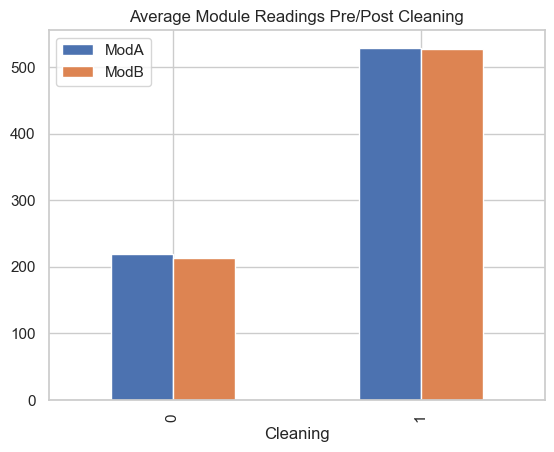

In [19]:
df_clean.reset_index(inplace=True)
df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().plot(kind='bar')
plt.title("Average Module Readings Pre/Post Cleaning")
plt.show()

## 8. Correlation Heatmap

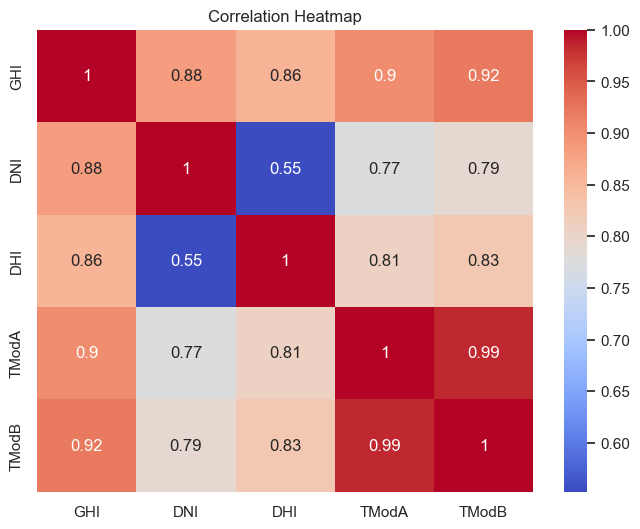

In [20]:
plt.figure(figsize=(8,6))
sns.heatmap(df_clean[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## 9. Scatter Plots

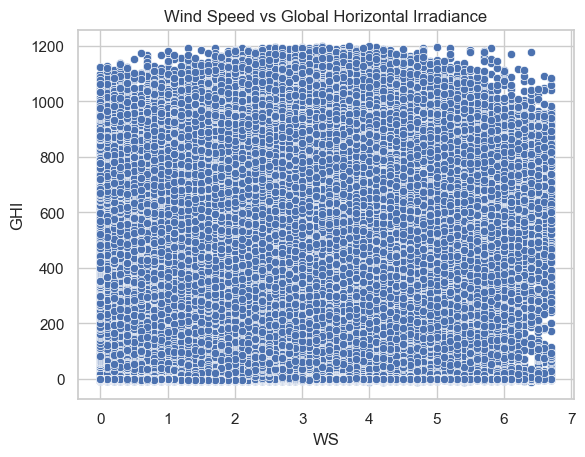

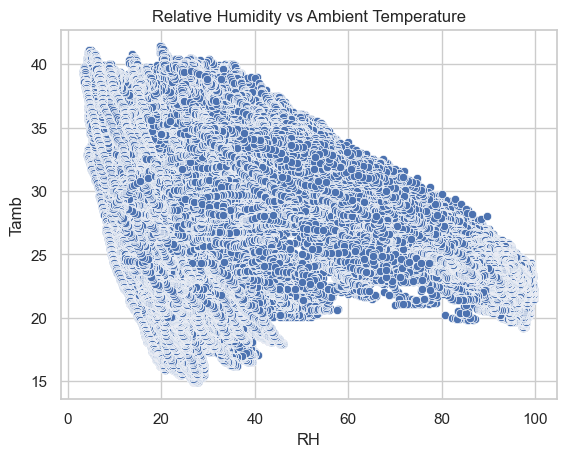

In [21]:
sns.scatterplot(x='WS', y='GHI', data=df_clean)
plt.title("Wind Speed vs Global Horizontal Irradiance")
plt.show()

sns.scatterplot(x='RH', y='Tamb', data=df_clean)
plt.title("Relative Humidity vs Ambient Temperature")
plt.show()


## 10. Wind & Distribution Analysis

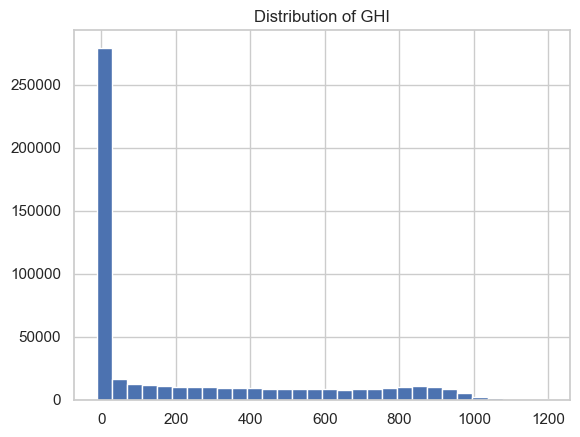

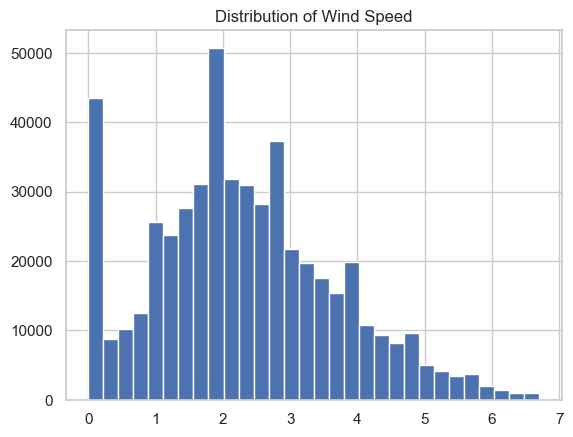

In [22]:
df_clean['GHI'].hist(bins=30)
plt.title("Distribution of GHI")
plt.show()

df_clean['WS'].hist(bins=30)
plt.title("Distribution of Wind Speed")
plt.show()


## 11. Temperature & Humidity Relationship (Bubble Chart)

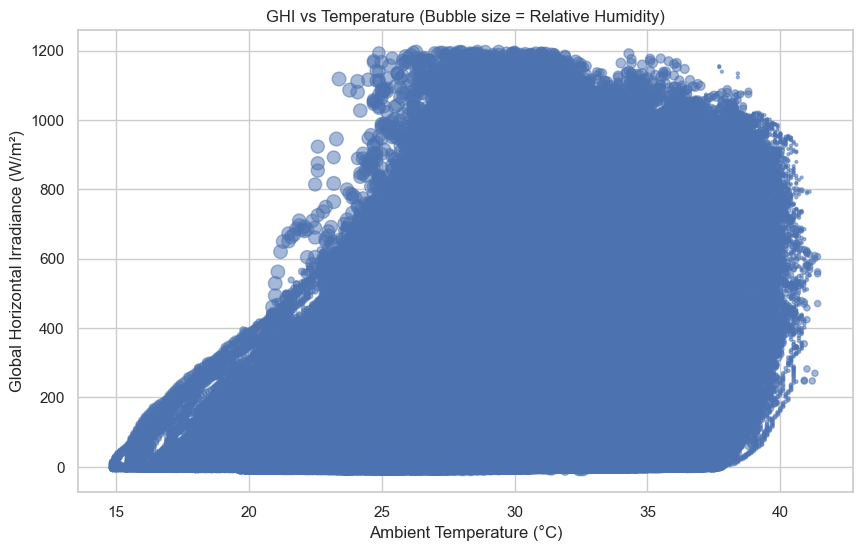

In [23]:
plt.figure(figsize=(10,6))
plt.scatter(df_clean['Tamb'], df_clean['GHI'], s=df_clean['RH'], alpha=0.5)
plt.xlabel("Ambient Temperature (°C)")
plt.ylabel("Global Horizontal Irradiance (W/m²)")
plt.title("GHI vs Temperature (Bubble size = Relative Humidity)")
plt.show()


## 12. Save Cleaned Dataset

In [24]:
df_clean.to_csv('../data/cleaned/togo_clean.csv', index=False)